<h1 align="center"><font size="7" face="arial" color="#73ACCD">Hands-On: TVMB The Virtual Mouse Brain</font></h1>
<h2 align="center"><font size="6" face="arial" color="#73ACCD">Perform resting-state MRI simulation on whole mouse brain</font></h2>

<br>
<h2 align="center"><font size="5" face="arial">March 9, 2020</font></h2>

<h3 align="center"><span style="font-weight:normal"><font size="5" face="arial">Patrik Bey</font></span></h3>
<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial">Charité Universitätsmedizin Berlin, Dept of Neurol, Brain Simulation Section, Berlin, Germany</font></span></h3>

<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial"><a href="mailto:patrik.bey@charite.de">patrik.bey@charite.de</a></font></span></h3>

<h1><font size="6" face="arial" color="#386766">Context</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
<b>The Virtual Mouse Brain (TVMB)</b> represents an extension to the open-source simulation software <b>The Virtual Brain (TVB)</b> to whole mouse brain network modeling based on individual diffusion magnetic resonance imaging (dMRI) based or tracer-based detailed mouse connectome. $^{[1]}$ </font></div></p>
    
    
<h1><font size="6" face="arial" color="#386766">Objectives</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman"> The main goal of this tutorial is to introduce the TVMB platform via the example presented in Melozzi et al. (2016)$^{[1]}$, and connect command line interface and graphical user interface for the given case. The given jupyter-notebook is strongly based on the provided example within the <i>simulate_for_mouse.ipyntb</i> demo within the TVB distribution.
</font></div></p>
    
    
<h1><font size="6" face="arial" color="#386766">How to do it with TVB?</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
The overall pipeline for the hands-on tutorial consists of the following five steps:<ul><br>
    <li>preparing the <i>workspace</i></li>
    <li>create <i>individual brain model</i></li>
    <li>run <i>simulation</i></li>
    <li>analyze <i>functional connectivity dynamics</i></li>
    <li><i>visualize</i> simulated whole brain activity</li>

    
<h1><font size="4" face="arial" color="#386766">Preparing workspace</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
The first thing we need to do is import the relevant TVB modules as well as define some helper functions for data handling.</font></div></p>

In [1]:
! pip install -U tvb-library
! pip install tvb-gdist==2.0.1
! pip install tvb-framework

Requirement already up-to-date: tvb-library in /opt/app-root/lib/python3.6/site-packages (2.0.9)
     |████████████████████████████████| 51.9 MB 33.8 MB/s eta 0:00:01MB 3.3 MB/s eta 0:00:1207██████▋       | 39.9 MB 33.8 MB/s eta 0:00:01:00:01███████▉| 51.6 MB 33.8 MB/s eta 0:00:01


In [2]:
!pip uninstall -y tvb-data
!wget https://zenodo.org/record/3688773/files/tvb-data.zip?download=1 -O $HOME/tvb_data.zip; \
    rm -rf $HOME/tvb_data; mkdir $HOME/tvb_data; unzip $HOME/tvb_data.zip -d $HOME/tvb_data; rm $HOME/tvb_data.zip; \
    cd $HOME/tvb_data; python setup.py develop

Found existing installation: tvb-data 2.0
Uninstalling tvb-data-2.0:
  Successfully uninstalled tvb-data-2.0
--2020-10-20 19:02:18--  https://zenodo.org/record/3688773/files/tvb-data.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 355927948 (339M) [application/octet-stream]
Saving to: ‘/opt/app-root/src/tvb_data.zip’

100%[======================================>] 355,927,948 71.1MB/s   in 5.1s   

2020-10-20 19:02:24 (66.0 MB/s) - ‘/opt/app-root/src/tvb_data.zip’ saved [355927948/355927948]

Archive:  /opt/app-root/src/tvb_data.zip
  inflating: /opt/app-root/src/tvb_data/Jenkinsfile  
  inflating: /opt/app-root/src/tvb_data/LICENSE  
  inflating: /opt/app-root/src/tvb_data/MANIFEST.in  
  inflating: /opt/app-root/src/tvb_data/README.rst  
  inflating: /opt/app-root/src/tvb_data/setup.py  
  inflating: /opt/app-root/src/tvb_data/tvb_data/Default

In [3]:
# init command profile
from tvb.basic.profile import TvbProfile
from tvb.core.services.settings_service import SettingsService
from sqlalchemy import create_engine, event
from tvb.core.entities.storage import SA_SESSIONMAKER
from tvb.config.init.initializer import initialize
! rm -rf $HOME/TVB
def build_db_engine():
    if TvbProfile.current.db.SELECTED_DB == 'postgres':
        ### Control the pool size for PostgreSQL, otherwise we might end with multiple
        ### concurrent Python processes failing because of too many opened connections.
        DB_ENGINE = create_engine(TvbProfile.current.db.DB_URL, pool_recycle=5, max_overflow=1,
                                  pool_size=TvbProfile.current.db.MAX_CONNECTIONS)
    else:
        ### SqlLite does not support pool-size
        DB_ENGINE = create_engine(TvbProfile.current.db.DB_URL, pool_recycle=5)

        def __have_journal_in_memory(con, con_record):
            con.execute("PRAGMA journal_mode = MEMORY")
            con.execute("PRAGMA synchronous = OFF")
            con.execute("PRAGMA temp_store = MEMORY")
            con.execute("PRAGMA cache_size = 500000")

        def __have_journal_WAL(con, con_record):
            con.execute("PRAGMA journal_mode=WAL")

        if getattr(TvbProfile.current, "TRADE_CRASH_SAFETY_FOR_SPEED", False):
            # use for speed, but without crash safety; use only in development
            LOGGER.warning("TRADE_CRASH_SAFETY_FOR_SPEED is on")
            event.listen(DB_ENGINE, 'connect', __have_journal_in_memory)
        else:
            event.listen(DB_ENGINE, 'connect', __have_journal_WAL)

    return DB_ENGINE

if TvbProfile.is_first_run():
    settings_service = SettingsService()
    settings = {}
    # Save default settings
    for key, setting in settings_service.configurable_keys.items():
        settings[key] = setting['value']
    settings_service.save_settings(**settings)
TvbProfile.set_profile(TvbProfile.COMMAND_PROFILE)
new_db_engine = build_db_engine()
SA_SESSIONMAKER.configure(bind=new_db_engine)

initialize()

2020-10-20 19:02:34,139 - WARNING - tvb.config.init.introspector_registry - Skipped Adapter(probably because MATLAB not found):<class 'tvb.adapters.analyzers.bct_adapters.DistanceDBIN'>
2020-10-20 19:02:34,143 - WARNING - tvb.config.init.introspector_registry - Skipped Adapter(probably because MATLAB not found):<class 'tvb.adapters.analyzers.bct_adapters.DistanceDWEI'>
2020-10-20 19:02:34,146 - WARNING - tvb.config.init.introspector_registry - Skipped Adapter(probably because MATLAB not found):<class 'tvb.adapters.analyzers.bct_adapters.DistanceNETW'>
2020-10-20 19:02:34,148 - WARNING - tvb.config.init.introspector_registry - Skipped Adapter(probably because MATLAB not found):<class 'tvb.adapters.analyzers.bct_adapters.DistanceRDA'>
2020-10-20 19:02:34,149 - WARNING - tvb.config.init.introspector_registry - Skipped Adapter(probably because MATLAB not found):<class 'tvb.adapters.analyzers.bct_adapters.DistanceRDM'>
2020-10-20 19:02:34,150 - WARNING - tvb.config.init.introspector_registr

In [4]:
# relevant TVB modules
from tvb.simulator.lab import *
LOG = get_logger('demo')
from tvb.simulator.plot.tools import *
from tvb.datatypes import time_series
from tvb.basic.config import settings
from tvb.basic.profile import TvbProfile
from tvb.datatypes.time_series import TimeSeriesRegion
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tvb.basic.readers import try_get_absolute_path

# required python packages
import numpy as np
import pylab
import matplotlib.pyplot as plt
import time
import h5py    
import uuid
import json
from datetime import datetime

# set visualization parameters
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

   INFO  log level set to INFO


defining helper functions

<h1><font size="4" face="arial" color="#386766">Create individual brain model</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
The individualized brain model is created using a tracer-based mouse brain connectome. It is provided within the TVB_data folder in the TVB_distribution as a structural connectivity matrix.</font></div></p>



In [5]:
# adjust path if run on local machine to default mouse data included in downloaded TVB distribution
# path = '/Applications/TVB_Distribution/tvb.app/Contents/Resources/lib/python2.7/tvb_data/mouse/allen_2mm/'
path=os.getcwd()

    

<h1><font size="3" face="arial" color="#386766">Allen Connectivity builder</font></h1>
<p><div style="text-align: justify"><font size="4.5" face="time roman"> The connectivity matrix was created using the <b>Allen Connectivity Builder</b>, a tool that downloads and manipulates the open-source tracer experiments of the Allen Institute (Oh et al., 2014 [2]), in order to built a connectome and the corresponding parcelled volumes. It is integrated within the TVMB framework and can create connectomes according to user given preferences:
    
<ul>
  <li> the resolution of the grid volume in which the experimental data have been registered (here 100 $\mu m$).
  <li> The definition of the connection strength between source region $i$ and target region $j$. (here $w_{ij}=\frac{PD_j}{ID_i}$, where PD=projection density, ID=injection density)</ul>
</font></div></p>


<p><div style="text-align: justify"><font size="4.5" face="time roman">It is possible to choose the characteristics of the brain areas to be included in the parcellation using the two following criteria:<ul>
    
 <li> Only brain areas where at least one injection has infected more than a given threshold of voxels. This kind of selection ensures that only the data with a certain level of experimental relevance is included in the connectome (Oh et al., 2014[2]), (here 50 voxels).
 <li> Only brain areas that have a volume greater than a given threshold can be included (here 2$mm^3$).</ul>


For a closer look at the underlying high resolution tracing data of the Allen Institute see <a href="https://connectivity.brain-map.org/projection">here</a>.</font></div></p>

<h1><font size="3" face="arial" color="#386766">Loading mouse connectome</font></h1>
<p><div style="text-align: justify"><font size="4.5" face="time roman">The provided connectivity matrix, in <b>H5</b> file format is loaded and plotted as heatmap.</font></div></p>

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


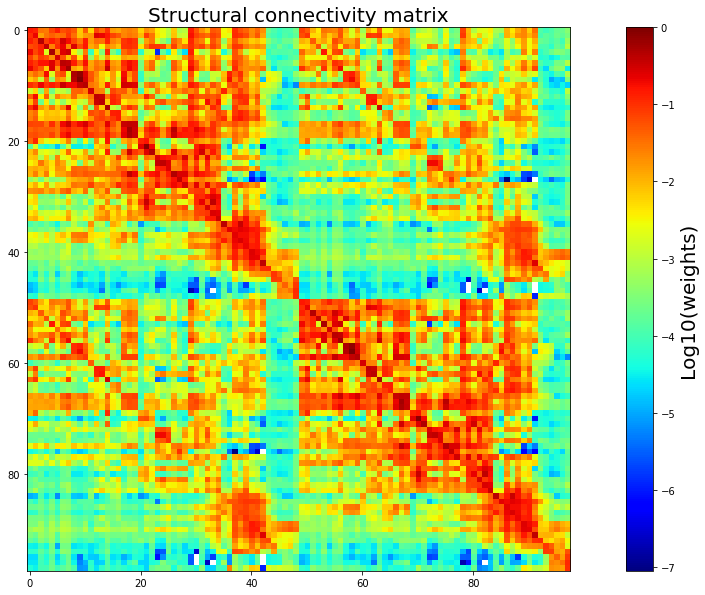

In [6]:
con = connectivity.Connectivity.from_file(os.path.join(path,"data",'Connectivity.h5'))

# Visualize the structural connectivity matrix
plt.subplots()
cs=plt.imshow(np.log10(con.weights), cmap='jet', aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)
plt.show()

In [7]:
from tvb.core.neocom import h5
from tvb.core.entities.storage import dao
from tvb.core.entities.file.files_helper import FilesHelper

# Store connectivity index
operation = dao.get_operation_by_id(1)
operation_folder = FilesHelper().get_project_folder(operation.project, str(operation.id))
conn_index = h5.store_complete(con,operation_folder)
conn_index.fk_from_operation = 1
conn_index = dao.store_entity(conn_index)

    
<h1><font size="4" face="arial" color="#386766">run simulation</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
After definition of the individual brain networks, it is possible to simulate its activity. To this end, we simulate resting-state dynamics using the reduced Wong Wang model (Deco et al. 2013 $^{[3]}$, Hansen et al., 2015 $^{[4]}$).

In order to convert the synaptic activity in BOLD signals, we use the Balloon-Windkessel method (Friston et al., 2000 $^{[5]}$) using the default value implemented in The Virtual Brain.
</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> To this end, we define the model and corresponding parameters as follows:

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
Run the created simulation.
</font></div></p>




In [8]:
from tvb.core.services.algorithm_service import AlgorithmService
from tvb.core.services.simulator_service import SimulatorService
from tvb.core.entities.model.model_burst import BurstConfiguration
from tvb.config.init.introspector_registry import IntrospectionRegistry
from tvb.core.entities.file.simulator.view_model import SimulatorAdapterModel, EulerStochasticViewModel, BoldViewModel, AdditiveNoiseViewModel
from time import sleep


TvbProfile.set_profile(TvbProfile.COMMAND_PROFILE)
project = dao.get_project_by_id(1)

# define the neural mass model (here: reduced wong wang)
RWW = models.ReducedWongWang(w=np.array(1.0), I_o=np.array(0.3))

#define variables to monitor during simulation (here: BOLD activity)
monitor = BoldViewModel()
monitor.period=2e3

#define long range coupling parameter
longcoupling = coupling.Linear(a=np.array(0.05))#096)

#define duration of simulation in ms
duration=60e3

#define integrator
integrator = EulerStochasticViewModel()
integrator.dt = 0.1
integrator.noise = AdditiveNoiseViewModel(nsig=np.array([0.00013]))

# Load the SimulatorAdapter algorithm from DB
cached_simulator_algorithm = AlgorithmService().get_algorithm_by_module_and_class(IntrospectionRegistry.SIMULATOR_MODULE,IntrospectionRegistry.SIMULATOR_CLASS)

# Instantiate a SimulatorAdapterModel and configure it
simulator_model = SimulatorAdapterModel()
simulator_model.model=RWW
simulator_model.connectivity = conn_index.gid
simulator_model.simulation_length = duration
simulator_model.coupling = longcoupling
simulator_model.integrator = integrator
simulator_model.monitors = [monitor]

burst = BurstConfiguration(project.id, name="Simulation")
dao.store_entity(burst)

launched_operation = SimulatorService().async_launch_and_prepare_simulation(burst,
                                                                            project.administrator, project,
                                                                            cached_simulator_algorithm,
                                                                            simulator_model)

# wait for the operation to finish
while not launched_operation.has_finished:
    sleep(5)
    launched_operation = dao.get_operation_by_id(launched_operation.id)

launched_operation

2020-10-20 19:02:43,723 - WARNING - tvb.traits - default contains values out of the declared domain. Ex 0.27 
   attribute  tvb.simulator.models.wong_wang.ReducedWongWang.a = NArray(label=':math:`a`', dtype=float64, default=array([0.27]), dim_names=(), ndim=None, required=True)
2020-10-20 19:02:43,724 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.wong_wang.ReducedWongWang.state_variable_range = Final(field_type=<class 'dict'>, default={'S': array([0., 1.])}, required=True)
2020-10-20 19:02:43,725 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.wong_wang.ReducedWongWang.state_variable_boundaries = Final(field_type=<class 'dict'>, default={'S': array([0., 1.])}, required=True)
2020-10-20 19:07:42,771 - INFO - tvb.core.services.backend_clients.standalone_client - Finished with launch of ope

<Operation('d620f48e49c34024abc8fa26849e1d64', 11f82c42-12f6-11eb-8d4d-0a580a800218, 2,'1','13','2020-10-20 19:02:43.766114','2020-10-20 19:02:48.422294', '2020-10-20 19:07:42.280103','5-FINISHED',True, 'None', '2020-10-20,19-07-42', '', 25.83984375)>

In [17]:
from tvb.core.services.project_service import ProjectService

sim_results = ProjectService().get_results_for_operation(launched_operation.id)
for result in sim_results:
    if result.type == 'TimeSeriesRegionIndex':
        ts_result_index = result

#Load time series h5 file
file = h5.h5_file_for_index(ts_result_index)
time_bold = file.time.load()
data_bold = file.data.load()

<p><div style="text-align: justify"><font size="4.5" face="time roman"> The simulated BOLD signals can be visualized using matplotlib library.</font></div></p>

Text(0.5, 1.0, 'Simulated BOLD timeseries')

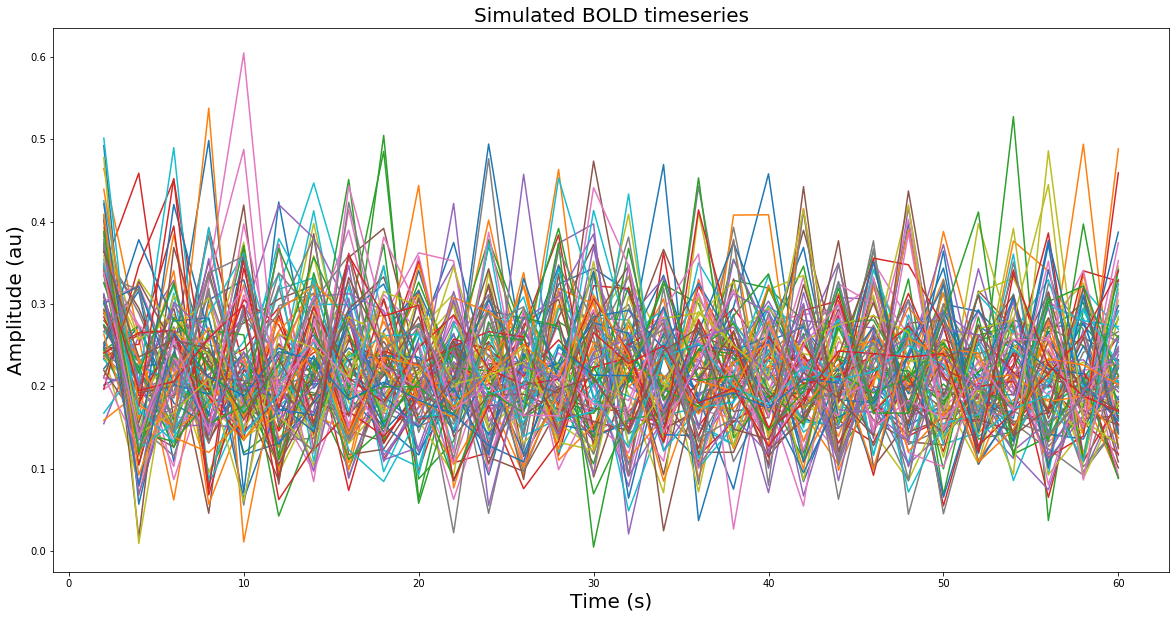

In [10]:
# Display the simulated bold timeseries
plt.subplots()
plt.plot(time_bold/1000,data_bold[:,0,:,0])
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)

    
<h1><font size="4" face="arial" color="#386766">Analysis</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
The simulated BOLD signal can be analyzed in various different ways. Here we follow Melozzi et al $^{[1]}$ and look at the functional connectivity dynamics. </font></div></p>

<h1><font size="3" face="arial" color="#386766">Functional connectivity dynamics</font></h1>
<p><div style="text-align: justify"><font size="4.5" face="time roman"> <b>Functional Connectivity Dynamics (FCD)</b> is a metric which is able to quantify the evolution of the functional states in time. There are several ways to estimate FCD (for a review Preti et al., 2016 [6]), TVB uses the sliding windows technique.



In order to estimate the FCD using the sliding window technique, the entire BOLD time-series is divided in time windows of a fixed length (here 30s) and with an overlap of 27 s; the data points within each window centered at the time $t_i$ were used to calculate FC($t_i$). 
The <i>ij</i>-th element of the FCD matrix is calculated as the Pearson correlation between the upper triangular part of the $FC(t_i)$ matrix arranged as a vector and the upper triangular part of the $FC(t_j)$ matrix arranged as a vector.


The FCD matrix allows identifying the epochs of stable FC configurations as blocks of elevated inter-$FC(t)$ correlation; these blocks are organized around the diagonal of the FCD matrix (Hansen et al., 2015 [4]).


In order to identify the epochs of stable FC configurations, TVB uses the spectral embedding method, that permits to group together the nodes of the FCD, i.e. the different time windows, in clusters.</font></div></p>



In [12]:
# Run FCD Adapter in order to compute the FCD Matrix
from tvb.adapters.analyzers.fcd_adapter import FCDAdapterModel,FunctionalConnectivityDynamicsAdapter
from tvb.adapters.datatypes.db.time_series import TimeSeriesRegionIndex
from tvb.adapters.datatypes.h5.time_series_h5 import TimeSeriesRegionH5
from tvb.core.neocom import h5
from tvb.core.entities.storage import dao
from tvb.core.entities.file.files_helper import FilesHelper
from tvb.core.adapters.abcadapter import ABCAdapterForm, ABCAdapter
from tvb.core.services.operation_service import OperationService
from time import sleep

adapter_instance = ABCAdapter.build_adapter_from_class(FunctionalConnectivityDynamicsAdapter)
project = dao.get_project_by_id(1)

# Create and evaluate the analysis
fcd_model = FCDAdapterModel()
fcd_model.time_series=ts_result_index.gid
fcd_model.sw=10e3 # windows length (ms)
fcd_model.sp=3e3 # spanning between sliding windows (ms)


# launch an operation and have the results stored both in DB and on disk
launched_operation = OperationService().fire_operation(adapter_instance, project.administrator,
                                                           project.id, view_model=fcd_model)[0]

# wait for the operation to finish
while not launched_operation.has_finished:
    sleep(5)
    launched_operation = dao.get_operation_by_id(launched_operation.id)

launched_operation

2020-10-20 19:07:45,900 - INFO - tvb.core.services.operation_service - Starting operation FunctionalConnectivityDynamicsAdapter
2020-10-20 19:07:45,960 - INFO - tvb.core.services.operation_service - Finished operation launch:FunctionalConnectivityDynamicsAdapter
2020-10-20 19:07:50,958 - INFO - tvb.core.services.backend_clients.standalone_client - Finished with launch of operation 9


<Operation('ec0493479b3c4cbb96c97cee84bb6371', c60fd6a8-12f6-11eb-8d4d-0a580a800218, 2,'1','3','2020-10-20 19:07:45.910988','2020-10-20 19:07:50.019810', '2020-10-20 19:07:50.412568','5-FINISHED',True, 'None', '2020-10-20,19-07-50', '', 0)>

In [13]:
# Fetch FCD Adapter results
from tvb.core.services.project_service import ProjectService

results = ProjectService().get_results_for_operation(launched_operation.id)
results

[<DataType(21, 3bb02b58c422468dbe6863cb930e0e2a, FcdIndex, tvb.adapters.datatypes.db.fcd, John Doe, INTERMEDIATE, f7e59a1d38374303acbc76b66adf283e, None, , , , )>,
 <DataType(22, 13488c4e032c4128b169479e07ac94c5, ConnectivityMeasure, tvb.adapters.datatypes.db.graph, John Doe, INTERMEDIATE, f7e59a1d38374303acbc76b66adf283e, None, , , , )>,
 <DataType(23, 1dcc417b1af745638976c0dd7aac8522, ConnectivityMeasure, tvb.adapters.datatypes.db.graph, John Doe, INTERMEDIATE, f7e59a1d38374303acbc76b66adf283e, None, , , , )>,
 <DataType(24, 80e712d8d02f43e4b2c3e5a18154d4b9, ConnectivityMeasure, tvb.adapters.datatypes.db.graph, John Doe, INTERMEDIATE, f7e59a1d38374303acbc76b66adf283e, None, , , , )>]

<p><div style="text-align: justify"><font size="4.5" face="time roman">The original and segmented FCD matrices can again be visualized using the matplotlib library.</font></div></p>


In [14]:
fcd_indexes = []
for analyzer_result in results:
    if analyzer_result.type=='FcdIndex':
        fcd_indexes.append(analyzer_result)
fcd_indexes

[<DataType(21, 3bb02b58c422468dbe6863cb930e0e2a, FcdIndex, tvb.adapters.datatypes.db.fcd, John Doe, INTERMEDIATE, f7e59a1d38374303acbc76b66adf283e, None, , , , )>]

FCD SEGMENTED SAME AS FCD


Text(0.5, 1.0, 'FCD segmented')

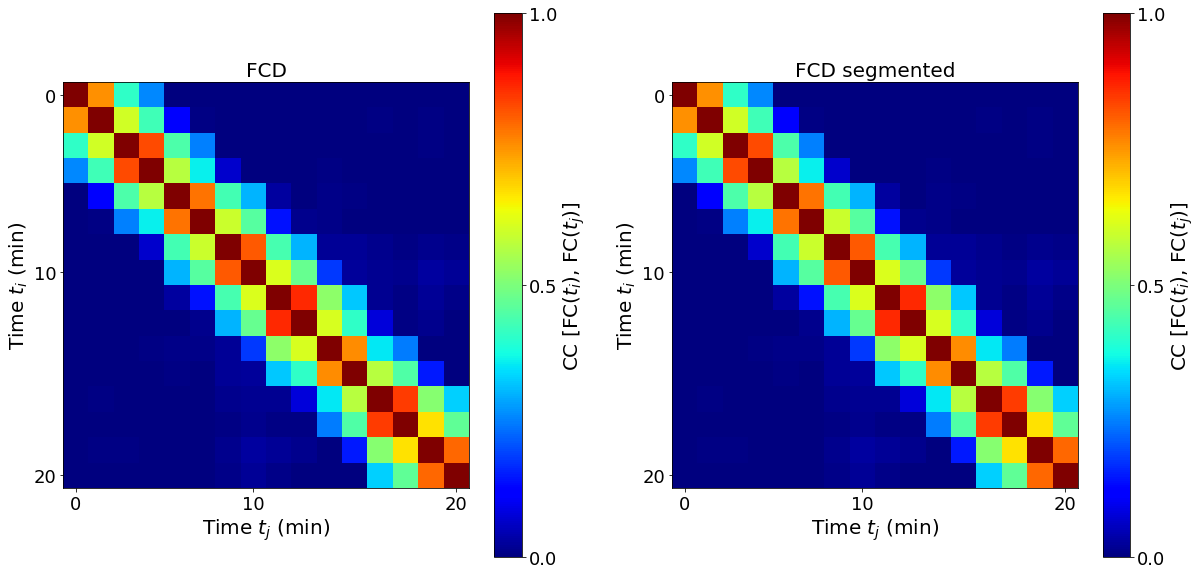

In [15]:
# Plot the FCD matrix and the FCD matrix segmented in the epochs
FCD = h5.h5_file_for_index(fcd_indexes[0]).array_data.load()[:,:,0,0]
try:
    FCD_SEGMENTED = h5.h5_file_for_index(fcd_indexes[1]).array_data.load()[:,:,0,0]
except Exception:
    print("FCD SEGMENTED SAME AS FCD")
    FCD_SEGMENTED = FCD
    
plt.subplot(121)
cs=plt.imshow(FCD, cmap='jet', aspect='equal')
axcb =plt.colorbar(ticks=[0, 0.5, 1])
axcb.set_label(r'CC [FC($t_i$), FC($t_j$)]', fontsize=20)
cs.set_clim(0, 1.0)
for t in axcb.ax.get_yticklabels():
     t.set_fontsize(18)
plt.xticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.yticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.xlabel(r'Time $t_j$ (min)', fontsize=20)
plt.ylabel(r'Time $t_i$ (min)', fontsize=20)
plt.title('FCD', fontsize=20)

plt.subplot(122)
cs=plt.imshow(FCD_SEGMENTED, cmap='jet', aspect='equal')
axcb =plt.colorbar(ticks=[0, 0.5, 1])
axcb.set_label(r'CC [FC($t_i$), FC($t_j$)]', fontsize=20)
cs.set_clim(0, 1.0)
for t in axcb.ax.get_yticklabels():
     t.set_fontsize(18)
plt.xticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.yticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.xlabel(r'Time $t_j$ (min)', fontsize=20)
plt.ylabel(r'Time $t_i$ (min)', fontsize=20)
plt.title('FCD segmented', fontsize=20)

<h1><font size="3" face="arial" color="#386766">Functional hubs</font></h1>
<p><div style="text-align: justify"><font size="4.5" face="time roman"> The functional connectivity matrix of each epoch defines a functional network; for each functional network, TVB identifies the hub regions with an approach analogous to the one used in graph theory for defining the eigenvector centrality of a network node (Newman 2008 $^{[7]}$). 

Here the functional hub regions of the mouse brain are defined as the regions with the largest eigenvector components, in absolute value, associated with the three largest eigenvalues of the FC matrix.


The functional hubs are an output of the FCD function (that we have just run), so we can save the results and display them in the mouse brain sections.

</font></div></p>

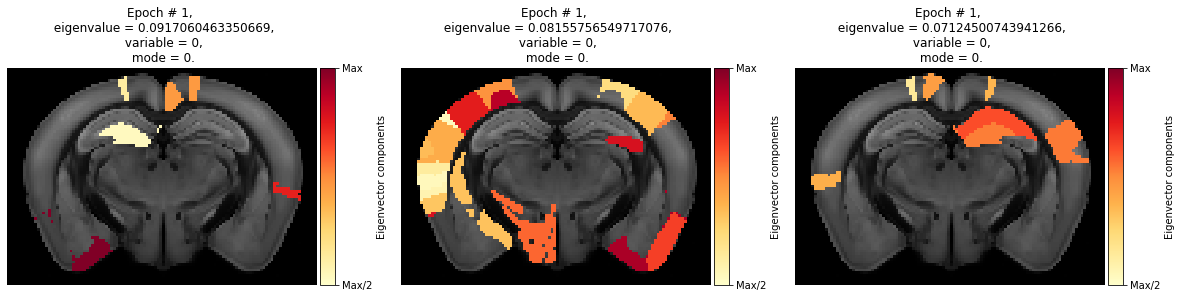

In [16]:
# Plot the functional hubs extracted in the first epoch of stable functional connectivity
# set visualization parameters
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

fig, axes = plt.subplots(1,3)
slice_idy=73
j=0
for result in results:
    if result.type == 'ConnectivityMeasure':
        f_path = os.path.join(path,'data','RegionVolumeMapping.h5')
        f = h5py.File(f_path, 'r', libver='latest')
        Vol=f['array_data'][:,:,:]
        f_path = os.path.join(path,'data','StructuralMRI.h5')
        f = h5py.File(f_path, 'r', libver='latest')
        template=f['array_data'][:,:,:]
        
        eig=h5.h5_file_for_index(result).array_data.load()
        
        for i in range(np.shape(eig)[0]):
            Vol[Vol==i]=eig[i]
        Vol = np.ma.masked_where(Vol < (np.amax(eig)/2), Vol)        
        im1 = axes[j].imshow((template[:,slice_idy,:].T)[::-1], cmap='gray', vmin=template.min(), vmax=template.max())
        cax = axes[j].imshow((Vol[:,slice_idy,:].T)[::-1], cmap='YlOrRd', alpha=1, vmin=np.amax(eig)/2., vmax=np.amax(eig))
        axes[j].axis('off')
        axes[j].set_title(result.title)
        divider = make_axes_locatable(axes[j])
        cax1 = divider.append_axes("right", size="5%", pad=0.05)
        axcb=plt.colorbar(cax,cax1,ticks=[np.amax(eig)/2.,np.amax(eig)],orientation='vertical')
        axcb.set_ticklabels(['Max/2', 'Max']) 
        axcb.set_label('Eigenvector components')
        j=j+1

<h1><font size="4" face="arial" color="#386766">References</font></h1>

[1] Melozzi, Francesca, Marmaduke Woodman, Viktor Jirsa, and Christophe Bernard. "The Virtual Mouse Brain: A Computational Neuroinformatics Platform To Study Whole Mouse Brain Dynamics." bioRxiv (2017): 123406.


[2] Oh, Seung Wook, Julie A. Harris, Lydia Ng, Brent Winslow, Nicholas Cain, Stefan Mihalas, Quanxin Wang et al. "A mesoscale connectome of the mouse brain." Nature 508, no. 7495 (2014): 207-214.


[3] Deco Gustavo, Ponce Alvarez Adrian, Dante Mantini, Gian Luca Romani, Patric Hagmann and Maurizio Corbetta. Resting-State Functional Connectivity Emerges from Structurally and Dynamically Shaped Slow Linear Fluctuations. The Journal of Neuroscience 32(27), 11239-11252, 2013.


[4] Hansen, Enrique CA, Demian Battaglia, Andreas Spiegler, Gustavo Deco, and Viktor K. Jirsa. "Functional connectivity dynamics: modeling the switching behavior of the resting state." Neuroimage 105 (2015): 525-535.


[5] Friston, Karl J., Andrea Mechelli, Robert Turner, and Cathy J. Price. "Nonlinear responses in fMRI: the Balloon model, Volterra kernels, and other hemodynamics." NeuroImage 12, no. 4 (2000): 466-477.


[6] Preti, Maria Giulia, Thomas AW Bolton, and Dimitri Van De Ville. "The dynamic functional connectome: State-of-the-art and perspectives." NeuroImage (2016).


[7] Newman, Mark EJ. "The mathematics of networks." The new palgrave encyclopedia of economics 2, no. 2008 (2008): 1-12.